# **<span style="color:rgb(223, 9, 9);">[CA3: Introduction to ML]</span>**

**<span style="color:rgb(255, 255, 0);">[AhmadReza Nopoush, id=610301194]</span>**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder,LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier , plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from xgboost import XGBClassifier
from collections import Counter

### **<span style="color:rgb(0, 255, 0);">[Preprocessing]</span>**

at first, we read data set from file:...

In [2]:
Dataset = pd.read_csv("Grades.csv")
Dataset

,university,sex,age,address,motherEducation,fatherEducation,motherJob,fatherJob,reason,travelTime,...,internet,romantic,freeTime,goOut,Dalc,Walc,absences,EPSGrade,DSGrade,finalGrade
0,PR,F,18,U,4,4,at_home,teacher,course,2,...,no,no,3,4,1,1,6,5,6,6
1,PR,F,17,U,1,1,at_home,other,course,1,...,yes,no,3,3,1,1,4,5,5,6
2,PR,F,15,U,1,1,at_home,other,other,1,...,yes,no,3,2,2,3,10,7,8,10
3,PR,F,15,U,4,2,health,services,home,1,...,yes,yes,2,2,1,1,2,15,14,15
4,PR,F,16,U,3,3,other,other,home,1,...,no,no,3,2,1,2,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,CM,M,21,R,1,1,other,other,course,1,...,no,no,5,3,3,3,3,10,8,7
393,CM,M,18,R,3,2,services,other,course,3,...,yes,no,4,1,3,4,0,11,12,10
394,CM,M,19,U,1,1,other,at_home,course,1,...,yes,no,2,3,3,3,5,8,9,9
395,PR,F,18,U,4,4,at_home,teacher,course,2,...,no,no,3,4,1,1,6,5,6,6


we see a distribution of categorical attributes below:

university: ['PR' 'CM']
sex: ['F' 'M']
address: ['U' 'R']
motherJob: ['at_home' 'health' 'other' 'services' 'teacher']
fatherJob: ['teacher' 'other' 'services' 'health' 'at_home']
reason: ['course' 'other' 'home' 'reputation']
universitySupport: ['yes' 'no']
paid: ['no' 'yes']
higher: ['yes' 'no']
internet: ['no' 'yes']
romantic: ['no' 'yes']


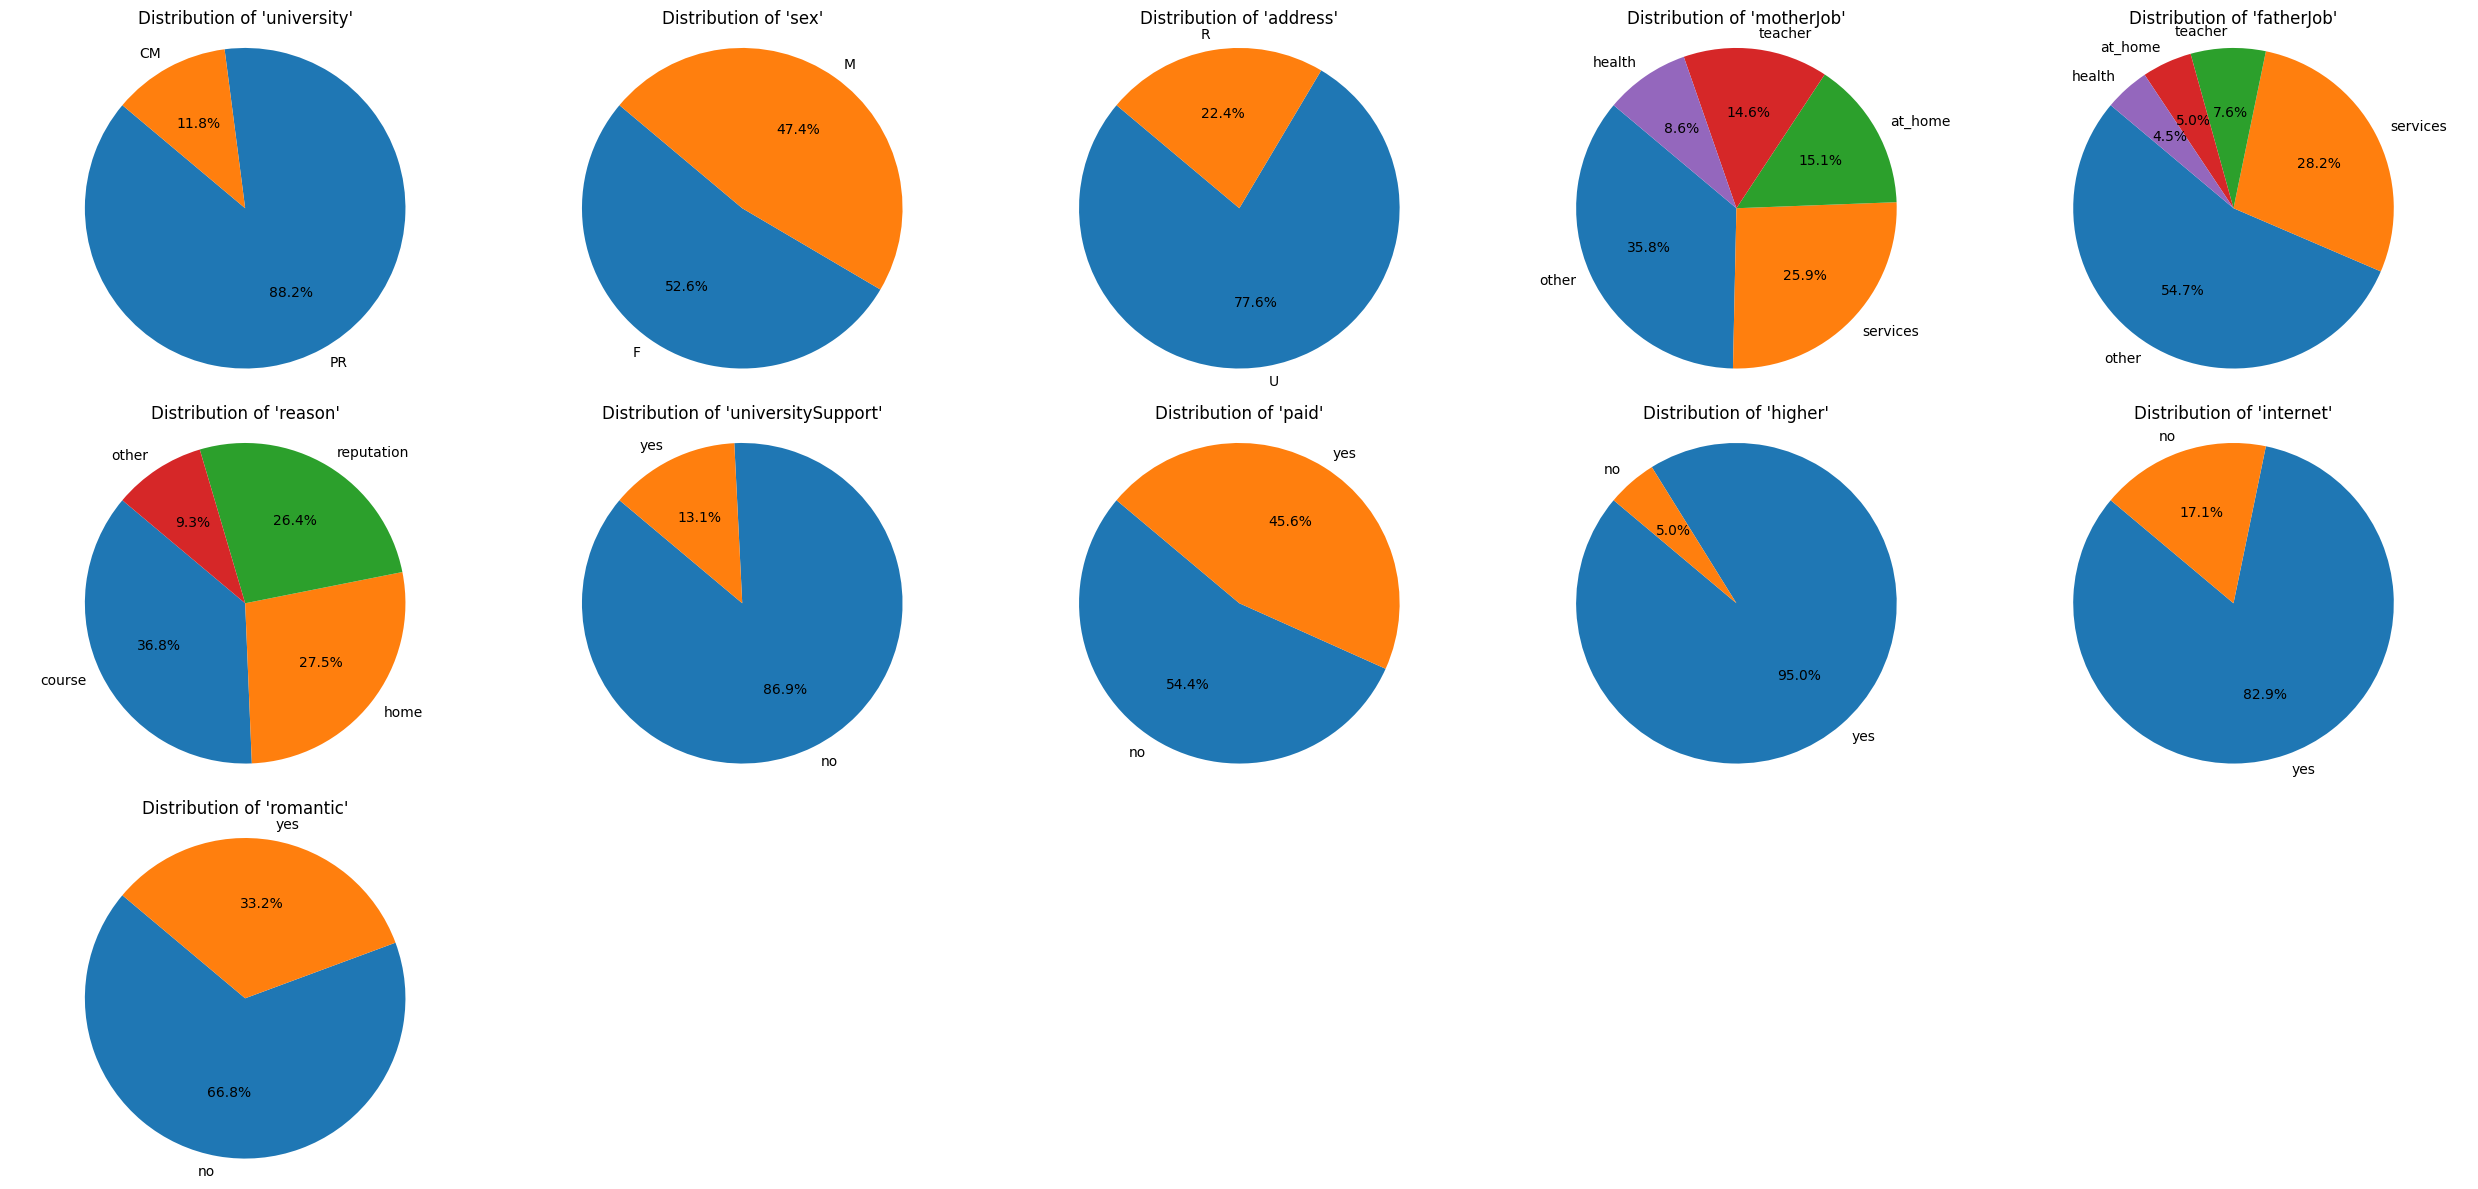

In [3]:
plt.figure(figsize=(25, 12))
i = 1
for col in Dataset.select_dtypes(include='object').columns:
    print(f"{col}: {Dataset[col].unique()}")
    value_counts = Dataset[col].value_counts()
    plt.subplot(3,5,i)
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f"Distribution of '{col}'")
    plt.axis('equal')
    i+=1
plt.tight_layout()
plt.show()

age: [18 17 15 16 19 22 20 21]
motherEducation: [4 1 3 2 0]
fatherEducation: [4 1 2 3 0]
travelTime: [2 1 3 4]
studyTime: [2 3 1 4]
failures: [0 3 2 1]
freeTime: [3 2 4 1 5]
goOut: [4 3 2 1 5]
Dalc: [1 2 5 3 4]
Walc: [1 3 2 4 5]
absences: [ 6  4 10  2  0 16 14  7  8 25 12 54 18 26 20 56 24 28  5 13 15 22  3 21
  1 75 30 19  9 11 38 40 23 17]
EPSGrade: [ 5  7 15  6 12 16 14 10 13  8 11  9 17 19 18  4  3]
DSGrade: [ 6  5  8 14 10 15 12 18 16 13  9 11  7 19 17  4  0]
finalGrade: [ 6 10 15 11 19  9 12 14 16  5  8 17 18 13 20  7  0  4]


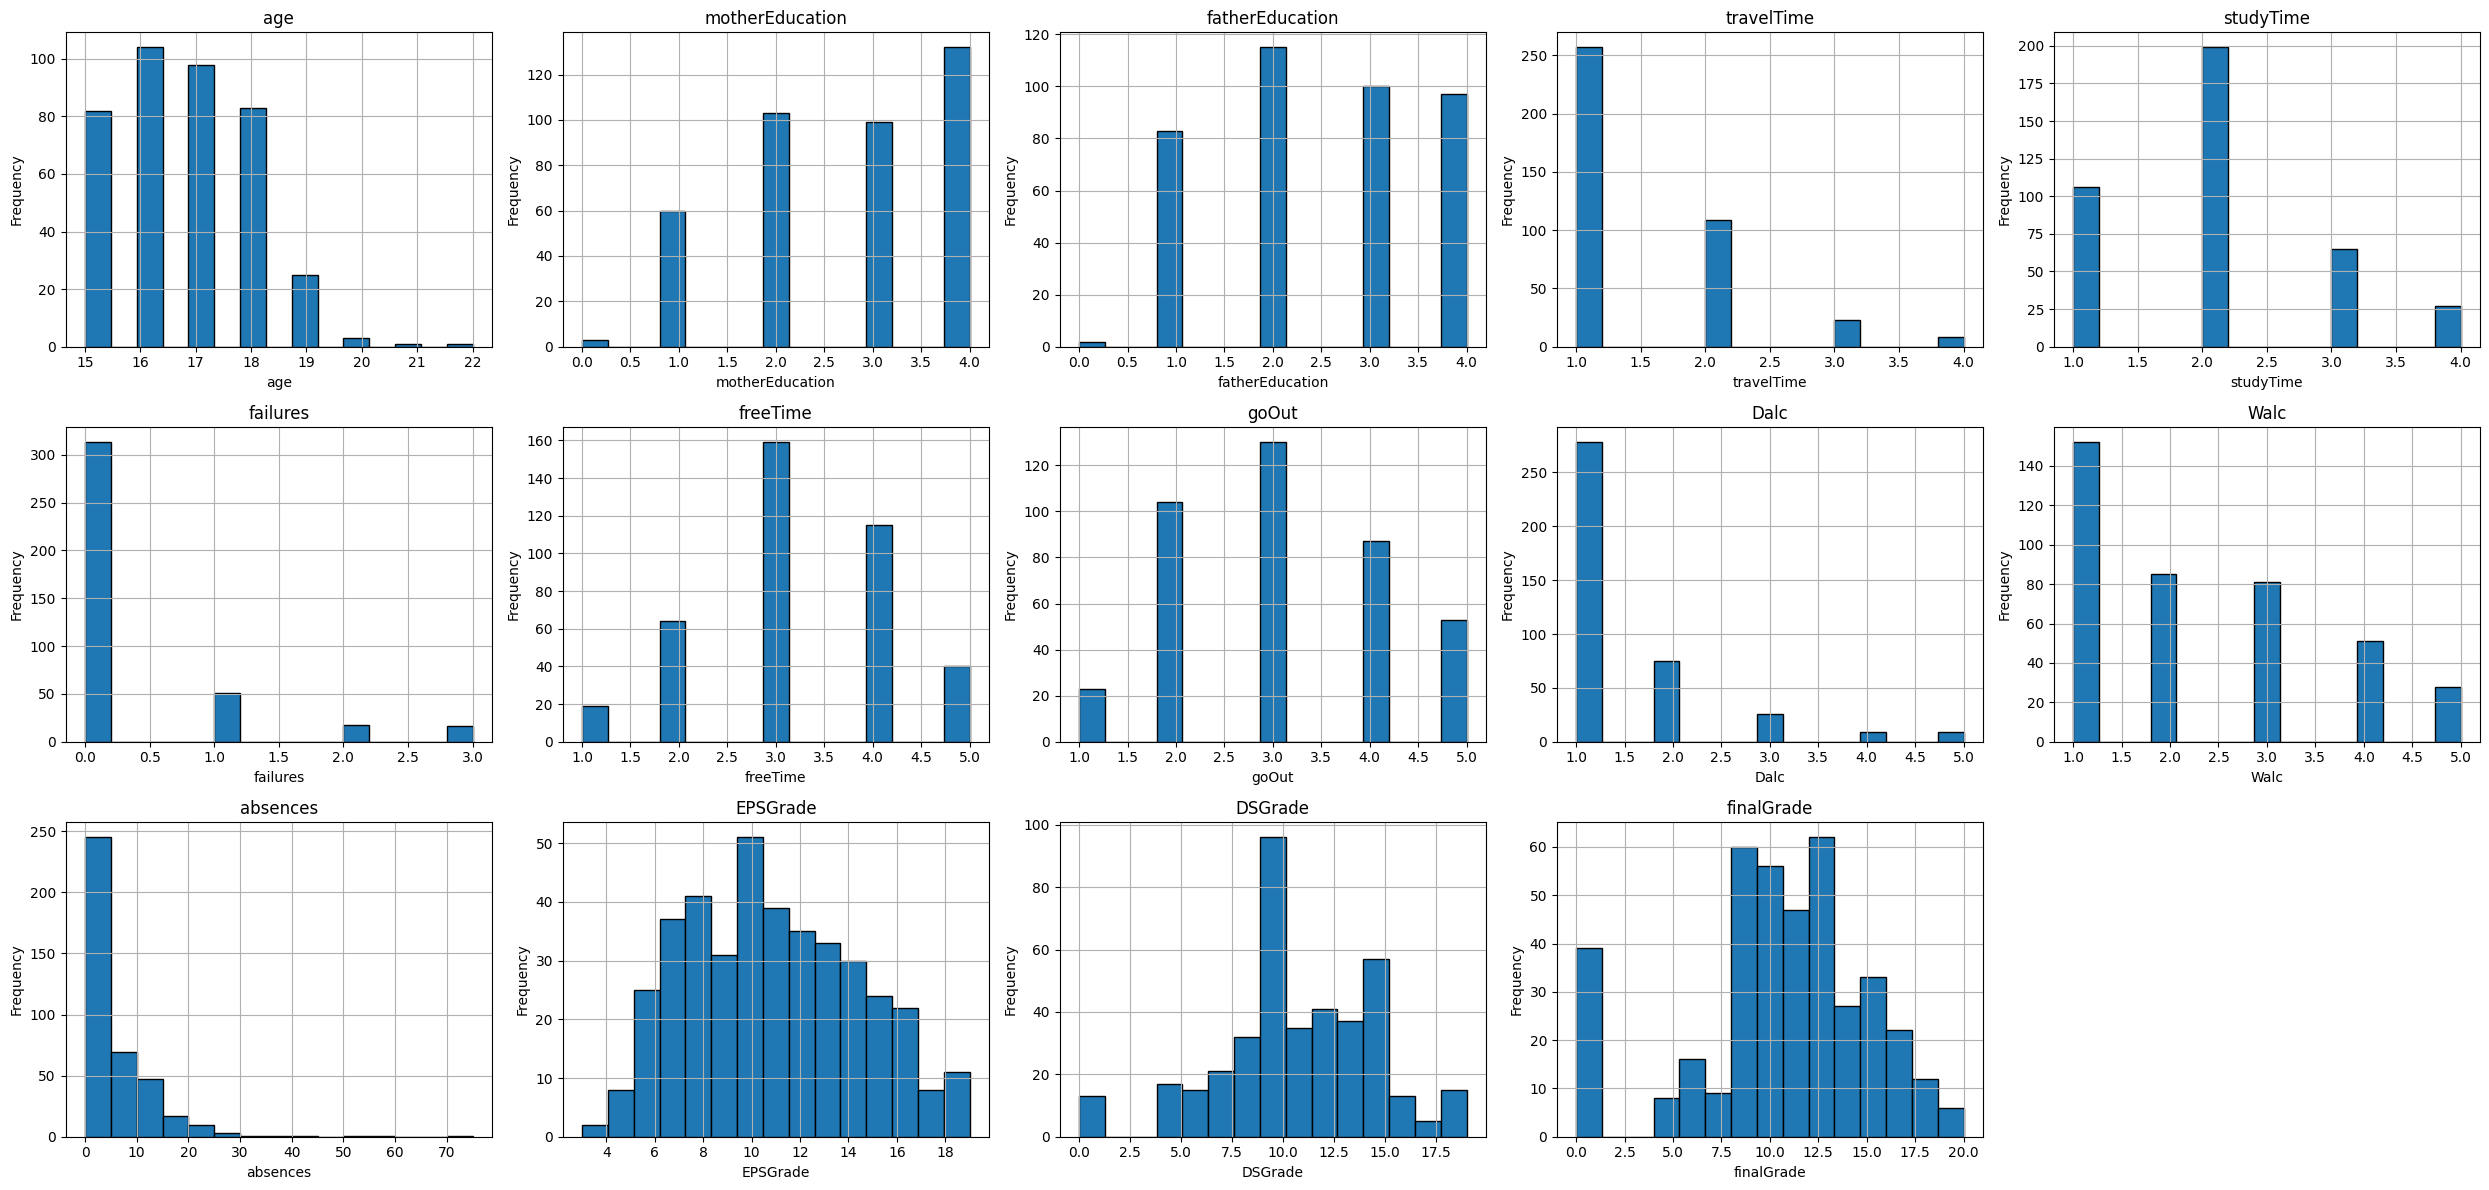

In [4]:
plt.figure(figsize=(25, 12))
i = 1
for col in Dataset.select_dtypes(include=['int64', 'float64']).columns:
    print(f"{col}: {Dataset[col].unique()}")
    plt.subplot(3,5,i)
    Dataset[col].hist(bins=15, edgecolor='black')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    i+=1
plt.tight_layout()
plt.show()

#### **<span style="color:rgb(0, 255, 255);">[Handling Missing Data]</span>**

to handle missing data, we have 3 ways:

1. **Removing**: in this way, we remove the frame that has missing value. this is a apporprite choice when have under 5% missing data.
2. **Replacing**: in this way, we set the missing value with the mean(for numerical variables) or the mode(for categorical variables) of the feature.
3. **Imputing**: in this way, we impute the missing value with a number generated from a distribution.

**Now, we see if there is missing data?**

as we can see from last part there is no missing data in our dataset.

#### **<span style="color:rgb(0, 255, 255);">[Convertion]</span>**

at first, we know that we want to develop Classification Tasks models; such as naive bayes, decision trees and random forest. so the target variable must be categorical, not numerical. so we convert numerical variable to categorical:

In [5]:
def convert_grade(grade):
    if grade > 17:
        return 3
    elif grade > 14:
        return 2
    elif grade >= 10:
        return 1
    else:
        return 0

DS = Dataset.copy()
DS['finalGrade'] = DS['finalGrade'].apply(convert_grade)

#### **<span style="color:rgb(0, 255, 255);">[Column Elimination]</span>**

as we can see from pie chart, in attributes ``motherjob`` and ``fatherjob`` the percentage of **other** value is high, and **other** value does not help us to mine a releation between fatherjob and ``finalBgrad``. so we eliminate this two column.

In [6]:
DS = DS.drop(columns=['fatherJob'])
DS = DS.drop(columns=['motherJob'])

DS['reason'] = DS['reason'].replace('other', DS['reason'].mode()[0])
DS = pd.get_dummies(DS,columns=['reason'])

#### **<span style="color:rgb(0, 255, 255);">[Convertion to binary variable]</span>**

as we can see in pie chart, most of our attributes are nominal categorical with 2 categories, and all of this can be converted into bool varible:

In [7]:
binaryConvertion = {
    'yes': 1, 'no': 0,
    'F': 0, 'M': 1,
    'U': 1, 'R': 0,
    'PR': 1, 'CM':0,
    True:1 , False:0
}

Binary_features = ['university', 'sex', 'address', 'universitySupport', 'paid', 'higher', 'internet', 'romantic','reason_course','reason_home','reason_reputation']
DS[Binary_features] = DS[Binary_features].replace(binaryConvertion)
DS.rename(columns={'university': 'IsUniPR', 'sex':'IsMale','address':'fromCity', 'higher':'EduTendency', 'internet':'HasInternet'}, inplace=True)


C:\Users\nopou\AppData\Local\Temp\ipykernel_11008\3978300386.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  DS[Binary_features] = DS[Binary_features].replace(binaryConvertion)


Note the type of each feature:

1. binary
2. numerical
3. ordinal categorical
4. nominal categorical

In [8]:
numerical_features = ['age', 'absences', 'EPSGrade', 'DSGrade']
ordinal_features = ['motherEducation', 'fatherEducation', 'travelTime',
                    'studyTime', 'failures', 'freeTime', 'goOut', 'Dalc', 'Walc']
binary_features = ['IsUniPR', 'IsMale', 'fromCity', 'universitySupport',
                   'paid', 'EduTendency', 'HasInternet', 'romantic']
nominal_features = ['reason']

here we represent the corelations among predictor variables. we can eliminate the predictor varibales which its corelation is high. like mother eEducation and father Education or Walc and Dalc. The reason is they carry very similar information. Keeping both just repeats the same signal in your model and Reducing correlated predictors simplifies the model and Prevents overfitting — the model focuses on unique signals, not repeated ones.

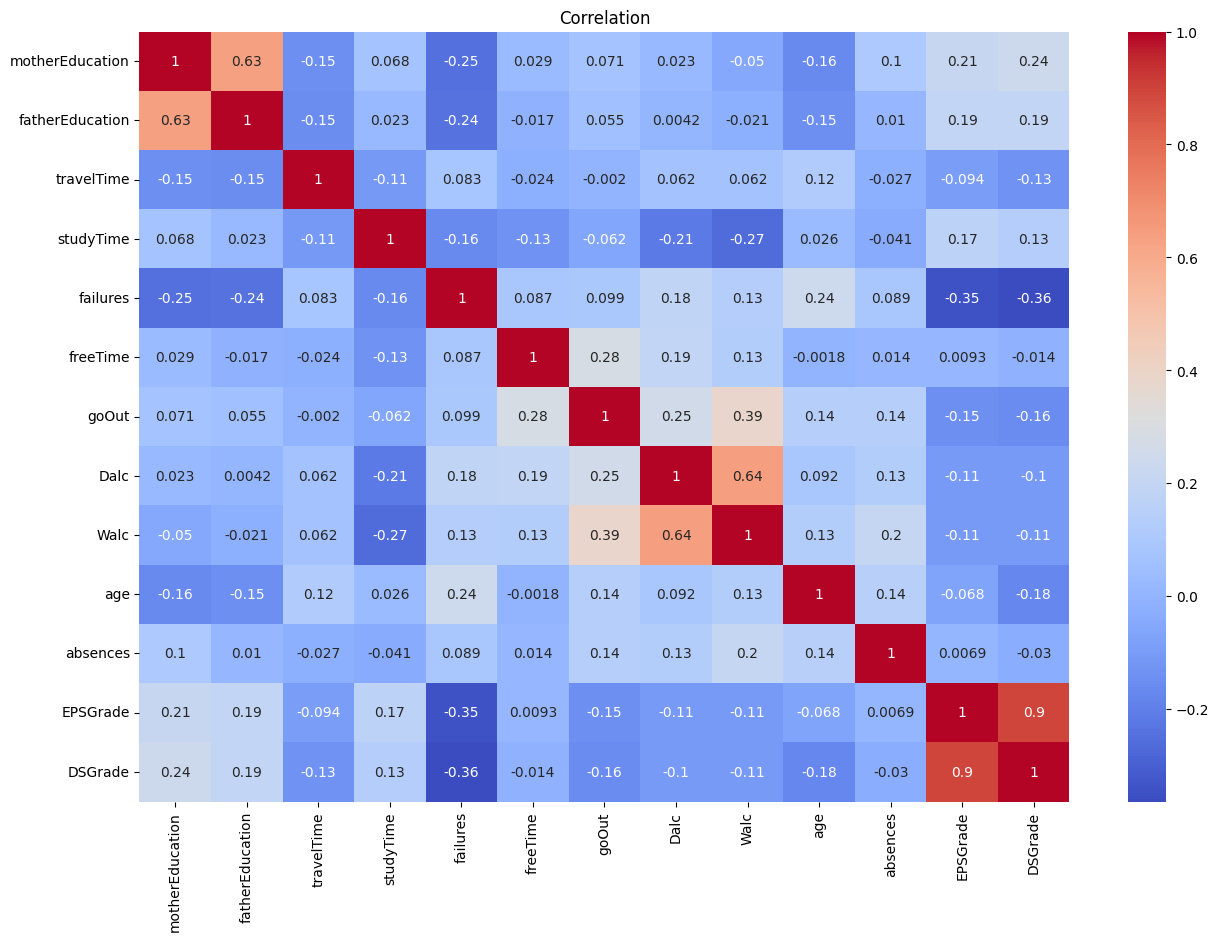

In [9]:
plt.figure(figsize=(15, 10))
sns.heatmap(DS[ordinal_features+numerical_features].corr(method='spearman'), annot=True, cmap='coolwarm')
plt.title("Correlation")
plt.show()

here we unite ``Dalc`` and ``Walc`` with ``alc``. `motherEducation` and `fatherEducation` are converted to `parentWdu` as well. as we can see in table we did not unite `DSGrade` and `EPSGrade`; because this two varible are highly correlated to target varibale, and Uniting them decreases model accuracy.

In [10]:
DS['alc'] = DS[['Dalc', 'Walc']].mean(axis=1)
DS.drop(columns=['Dalc', 'Walc'], inplace=True)

DS['parentEdu'] = DS[['motherEducation', 'fatherEducation']].mean(axis=1)
DS.drop(columns=['motherEducation', 'fatherEducation'], inplace=True)

now we update  features

In [11]:
numerical_features = ['age', 'absences', 'EPSGrade', 'DSGrade']
ordinal_features = ['parentEdu', 'travelTime',
                    'studyTime', 'failures', 'freeTime', 'goOut', 'alc']
binary_features = ['IsUniPR', 'IsMale', 'fromCity', 'universitySupport',
                   'paid', 'EduTendency', 'HasInternet', 'romantic']
nominal_features = ['reason']

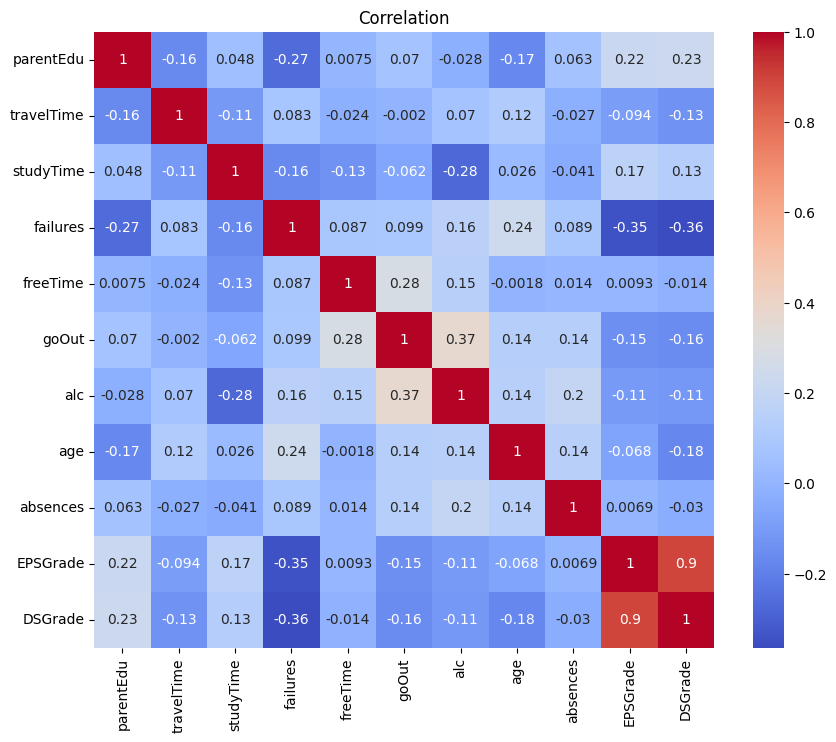

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(DS[ordinal_features+numerical_features].corr(method='spearman'), annot=True, cmap='coolwarm')
plt.title("Correlation")
plt.show()

Now we finished, preprocessing. at last Note the type of each feature:

1. binary
2. numerical
3. ordinal categorical
4. nominal categorical

In [13]:
DS

,IsUniPR,IsMale,age,fromCity,travelTime,studyTime,failures,universitySupport,paid,EduTendency,...,goOut,absences,EPSGrade,DSGrade,finalGrade,reason_course,reason_home,reason_reputation,alc,parentEdu
0,1,0,18,1,2,2,0,1,0,1,...,4,6,5,6,0,1,0,0,1.0,4.0
1,1,0,17,1,1,2,0,0,0,1,...,3,4,5,5,0,1,0,0,1.0,1.0
2,1,0,15,1,1,2,3,1,1,1,...,2,10,7,8,1,1,0,0,2.5,1.0
3,1,0,15,1,1,3,0,0,1,1,...,2,2,15,14,2,0,1,0,1.0,3.0
4,1,0,16,1,1,2,0,0,1,1,...,2,4,6,10,1,0,1,0,1.5,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,0,1,21,0,1,1,3,0,0,1,...,3,3,10,8,0,1,0,0,3.0,1.0
393,0,1,18,0,3,1,0,0,0,1,...,1,0,11,12,1,1,0,0,3.5,2.5
394,0,1,19,1,1,1,0,0,0,1,...,3,5,8,9,0,1,0,0,3.0,1.0
395,1,0,18,1,2,2,0,1,0,1,...,4,6,5,6,0,1,0,0,1.0,4.0


### **<span style="color:rgb(0, 255, 0);">[Normalization]</span>**

#### **<span style="color:rgb(0, 255, 255);">[Train/Test Split]</span>**

In [14]:
X = DS.drop(columns=['finalGrade'])
y = DS['finalGrade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Xt = X_train.copy()

XA_train = X_train.copy()
XA_test = X_test.copy()
yA_train = y_train.copy()
yA_test = y_test.copy()

#### **<span style="color:rgb(0, 255, 255);">[Normalization]</span>**

we use `MinMaxScaler` to normalize data. This scaler convert each varibale to a number between 0 to 1

In [15]:
scaler = MinMaxScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

X_train[ordinal_features] = scaler.fit_transform(X_train[ordinal_features])
X_test[ordinal_features] = scaler.transform(X_test[ordinal_features])


here we can see how X_train are Normalized:

In [16]:
X_train

,IsUniPR,IsMale,age,fromCity,travelTime,studyTime,failures,universitySupport,paid,EduTendency,...,freeTime,goOut,absences,EPSGrade,DSGrade,reason_course,reason_home,reason_reputation,alc,parentEdu
262,1,1,0.6,0,0.000000,0.666667,0.000000,0,0,1,...,0.50,0.25,0.013333,0.600000,0.631579,1,0,0,0.000,0.571429
113,1,1,0.0,1,0.000000,0.000000,0.000000,0,0,1,...,1.00,0.25,0.133333,0.933333,1.000000,1,0,0,0.000,0.714286
176,1,0,0.2,1,0.333333,0.333333,0.000000,0,1,1,...,0.75,0.75,0.026667,0.600000,0.684211,0,0,1,0.375,0.428571
63,1,0,0.2,1,0.000000,0.666667,0.000000,1,1,1,...,0.75,0.75,0.026667,0.400000,0.473684,0,1,0,0.500,0.857143
245,1,1,0.2,1,0.666667,0.000000,0.000000,0,0,1,...,0.50,0.50,0.080000,0.933333,0.947368,1,0,0,0.000,0.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,1,1,0.0,1,0.000000,1.000000,0.000000,0,0,1,...,0.50,0.50,0.000000,0.400000,0.526316,1,0,0,0.000,0.714286
106,1,0,0.0,1,0.000000,1.000000,0.000000,1,1,1,...,0.00,0.25,0.106667,0.200000,0.421053,1,0,0,0.000,0.428571
270,1,0,0.8,1,0.000000,0.333333,0.666667,0,1,1,...,0.50,1.00,0.200000,0.333333,0.473684,0,1,0,0.500,0.714286
348,1,0,0.4,1,0.000000,0.666667,0.000000,0,1,1,...,0.75,0.50,0.000000,0.600000,0.789474,0,0,1,0.250,0.857143


### **<span style="color:rgb(0, 255, 0);">[Naive Bayes]</span>**


Accuracy: 0.6125

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.71      0.78        28
           1       0.64      0.41      0.50        34
           2       0.43      0.81      0.57        16
           3       0.40      1.00      0.57         2

    accuracy                           0.61        80
   macro avg       0.58      0.73      0.61        80
weighted avg       0.67      0.61      0.61        80



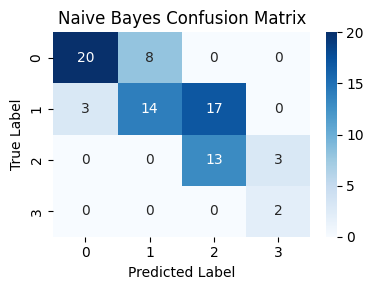

In [17]:
NB = GaussianNB()
NB.fit(X_train, y_train)

# Predict
y_pred_NB = NB.predict(X_test)

# Evaluation
conf_matrix_NB = confusion_matrix(y_test, y_pred_NB)
accuracy_NB = accuracy_score(y_test, y_pred_NB)
class_report_NB = classification_report(y_test, y_pred_NB)

# Output results
print("\nAccuracy:", accuracy_NB)
print("\nClassification Report:\n", class_report_NB)

# Plot it
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_NB, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Naive Bayes Confusion Matrix")
plt.tight_layout()
plt.show()

### **<span style="color:rgb(0, 255, 0);">[Decision Tree]</span>**


Accuracy: 0.875

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91        28
           1       0.86      0.91      0.89        34
           2       1.00      0.69      0.81        16
           3       0.50      1.00      0.67         2

    accuracy                           0.88        80
   macro avg       0.81      0.88      0.82        80
weighted avg       0.89      0.88      0.88        80



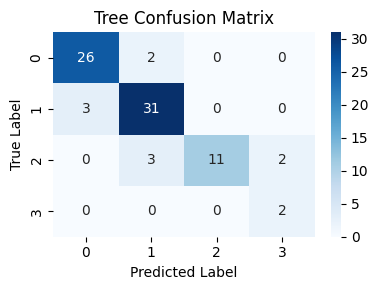

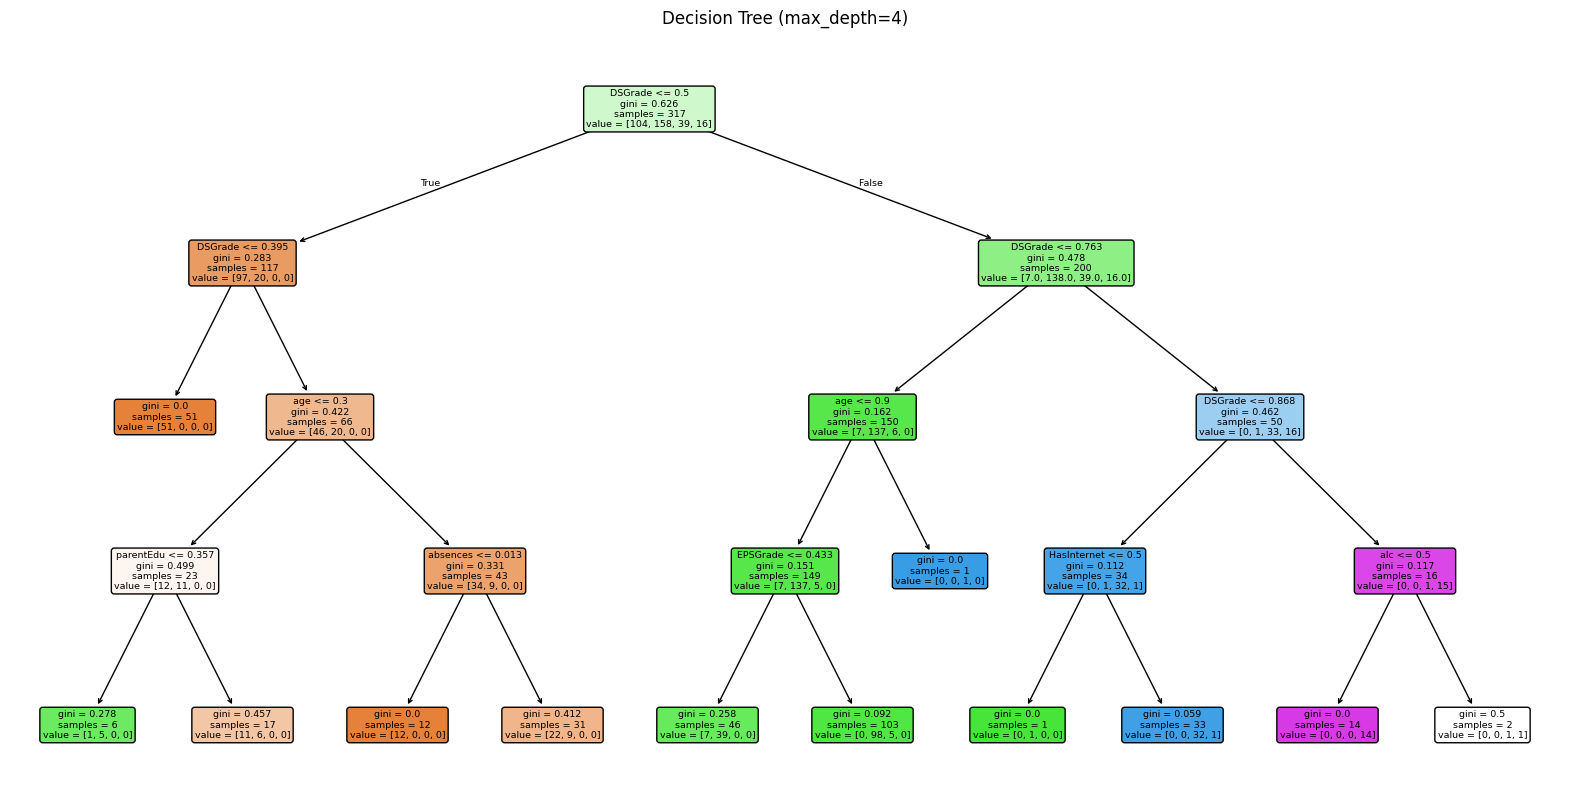

In [18]:
DT = DecisionTreeClassifier(max_depth=4, random_state=42)
DT.fit(X_train, y_train)

# Predict
y_pred_DT = DT.predict(X_test)

# Evaluation
accuracy_DT = accuracy_score(y_test, y_pred_DT)
class_report_DT = classification_report(y_test, y_pred_DT)
conf_matrix_DT = confusion_matrix(y_test, y_pred_DT)

# Output results
print("\nAccuracy:", accuracy_DT)
print("\nClassification Report:\n", class_report_DT)

# Plot it
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_DT, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Tree Confusion Matrix")
plt.tight_layout()
plt.show()

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(DT, 
          feature_names=X.columns, 
          filled=True, 
          rounded=True)
plt.title("Decision Tree (max_depth=4)")
plt.show()

#### **<span style="color:rgb(0, 255, 255);">[Optimizing Hyperparameters]</span>**

In [19]:
param_dist = {
    'max_depth': randint(1, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'criterion': ['gini', 'entropy','log_loss']
}

random_search = RandomizedSearchCV(estimator=DT, param_distributions=param_dist,
                                   n_iter=20, cv=5, n_jobs=-1, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000019A572E5400>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000019A5CA0D310>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000019A5CE1D310>},
                   random_state=42, scoring='accuracy')


Accuracy: 0.9

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.92        28
           1       0.94      0.88      0.91        34
           2       1.00      0.81      0.90        16
           3       0.50      1.00      0.67         2

    accuracy                           0.90        80
   macro avg       0.83      0.91      0.85        80
weighted avg       0.92      0.90      0.90        80



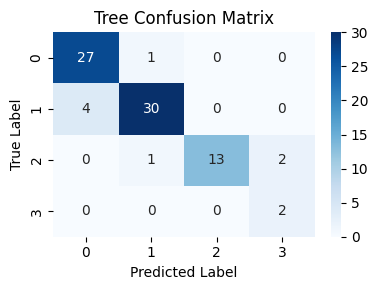

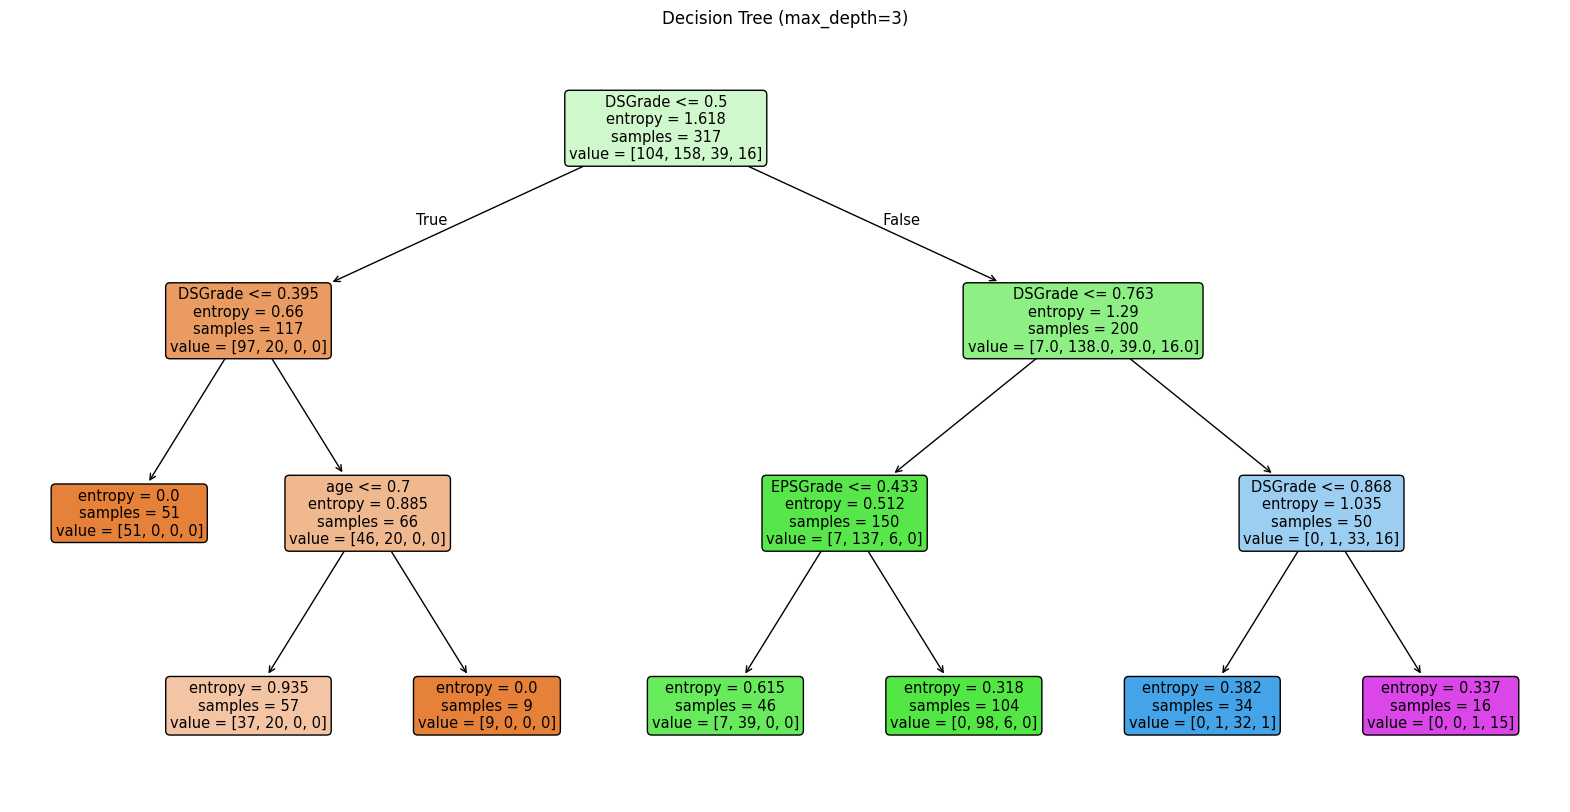

In [20]:
ODT = random_search.best_estimator_
ODT.fit(X_train, y_train)

# Predict
y_pred_ODT = ODT.predict(X_test)

# Evaluation
accuracy_ODT = accuracy_score(y_test, y_pred_ODT)
class_report_ODT = classification_report(y_test, y_pred_ODT)
conf_matrix_ODT = confusion_matrix(y_test, y_pred_ODT)

# Output results
print("\nAccuracy:", accuracy_ODT)
print("\nClassification Report:\n", class_report_ODT)

# Plot it
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_ODT, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Tree Confusion Matrix")
plt.tight_layout()
plt.show()

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(ODT, 
          feature_names=X.columns, 
          filled=True, 
          rounded=True)
plt.title("Decision Tree (max_depth=3)")
plt.show()

     Feature  Importance
16   DSGrade    0.946128
15  EPSGrade    0.040386
2        age    0.013487
3   fromCity    0.000000
1     IsMale    0.000000


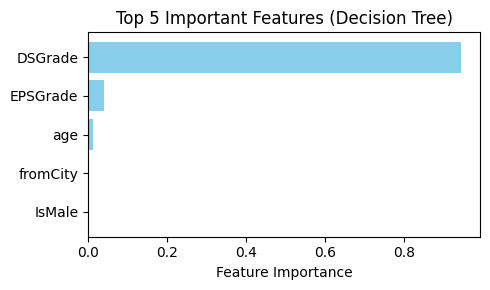

In [21]:
# Get feature importances
importances = ODT.feature_importances_

# Match with feature names
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top 10
print(feature_importance_df.head(5))

top_features = feature_importance_df.head(5)

plt.figure(figsize=(5, 3))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Highest importance on top
plt.title(f"Top {5} Important Features (Decision Tree)")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

### **<span style="color:rgb(0, 255, 0);">[Random Forest]</span>**


Accuracy: 0.9125

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93        28
           1       0.91      0.91      0.91        34
           2       0.93      0.88      0.90        16
           3       1.00      0.50      0.67         2

    accuracy                           0.91        80
   macro avg       0.94      0.81      0.85        80
weighted avg       0.91      0.91      0.91        80



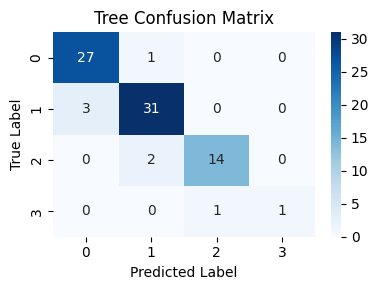

In [22]:
RF = RandomForestClassifier(random_state=42)
RF.fit(X_train, y_train)

# Predict
y_pred_RF = RF.predict(X_test)

# Evaluation
accuracy_RF = accuracy_score(y_test, y_pred_RF)
class_report_RF = classification_report(y_test, y_pred_RF)
conf_matrix_RF = confusion_matrix(y_test, y_pred_RF)

# Output results
print("\nAccuracy:", accuracy_RF)
print("\nClassification Report:\n", class_report_RF)

# Plot it
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_RF, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Tree Confusion Matrix")
plt.tight_layout()
plt.show()

#### **<span style="color:rgb(0, 255, 255);">[Optimizing Hyperparameters]</span>**

In [23]:
param_dist = {
    'n_estimators': randint(200, 400),
    'max_depth': [None, 5, 10, 15,20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4),
    'criterion': ['gini', 'entropy','log_loss']
}

random_search = RandomizedSearchCV(estimator=RF, param_distributions=param_dist,
                                   n_iter=20, cv=5, n_jobs=-1, scoring='accuracy', random_state=42)
random_search.fit(X, y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [None, 5, 10, 15, 20],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000019A5990A570>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000019A57326190>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000019A573268B0>},
                   random_state=42, scoring='accuracy')


Accuracy: 0.9125

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93        28
           1       0.91      0.91      0.91        34
           2       0.93      0.88      0.90        16
           3       1.00      0.50      0.67         2

    accuracy                           0.91        80
   macro avg       0.94      0.81      0.85        80
weighted avg       0.91      0.91      0.91        80



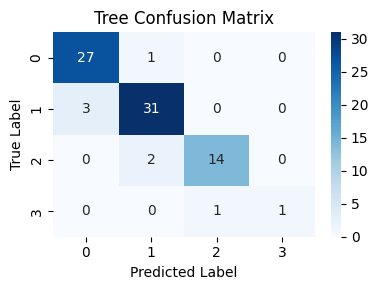

In [24]:
ORF = random_search.best_estimator_
ORF.fit(X_train, y_train)

# Predict
y_pred_ORF = ORF.predict(X_test)

# Evaluation
accuracy_ORF = accuracy_score(y_test, y_pred_ORF)
class_report_ORF = classification_report(y_test, y_pred_ORF)
conf_matrix_ORF = confusion_matrix(y_test, y_pred_ORF)

# Output results
print("\nAccuracy:", accuracy_ORF)
print("\nClassification Report:\n", class_report_ORF)

# Plot it
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_ORF, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Tree Confusion Matrix")
plt.tight_layout()
plt.show()

### **<span style="color:rgb(0, 255, 0);">[XGBoost]</span>**

c:\Users\nopou\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:21:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Accuracy: 0.8875

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91        28
           1       0.91      0.88      0.90        34
           2       0.93      0.81      0.87        16
           3       0.50      1.00      0.67         2

    accuracy                           0.89        80
   macro avg       0.81      0.91      0.84        80
weighted avg       0.90      0.89      0.89        80



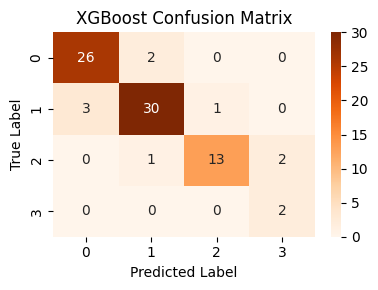

In [25]:
XGB = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
XGB.fit(X_train, y_train)

# Predict
y_pred_XGB = XGB.predict(X_test)

# Evaluation
accuracy_XGB = accuracy_score(y_test, y_pred_XGB)
class_report_XGB = classification_report(y_test, y_pred_XGB)
conf_matrix_XGB = confusion_matrix(y_test, y_pred_XGB)

# Output results
print("\nAccuracy:", accuracy_XGB)
print("\nClassification Report:\n", class_report_XGB)

# Plot it
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_XGB, annot=True, fmt="d", cmap="Oranges")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost Confusion Matrix")
plt.tight_layout()
plt.show()

#### **<span style="color:rgb(0, 255, 255);">[Optimizing Hyperparameters]</span>**

In [26]:
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 150],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.2],
    'colsample_bytree': [0.6, 0.8, 1]
}

grid_search = GridSearchCV(
    estimator=XGB,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X, y)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


c:\Users\nopou\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:22:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constrain...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1], 'gamma': [0, 0.2],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3],
                         'n_estimators': [100, 150]},
             scoring='accuracy', verbose=1)

c:\Users\nopou\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:22:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Accuracy: 0.9

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91        28
           1       0.91      0.91      0.91        34
           2       1.00      0.81      0.90        16
           3       0.50      1.00      0.67         2

    accuracy                           0.90        80
   macro avg       0.83      0.91      0.85        80
weighted avg       0.91      0.90      0.90        80



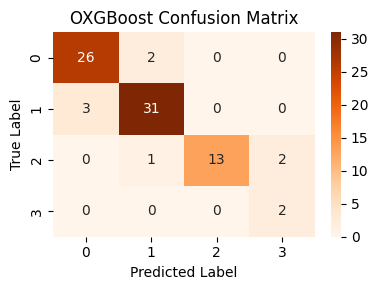

In [27]:
OXGB = grid_search.best_estimator_
OXGB.fit(X_train, y_train)

# Predict
y_pred_OXGB = OXGB.predict(X_test)

# Evaluation
accuracy_OXGB = accuracy_score(y_test, y_pred_OXGB)
class_report_OXGB = classification_report(y_test, y_pred_OXGB)
conf_matrix_OXGB = confusion_matrix(y_test, y_pred_OXGB)

# Output results
print("\nAccuracy:", accuracy_OXGB)
print("\nClassification Report:\n", class_report_OXGB)

# Plot it
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_OXGB, annot=True, fmt="d", cmap="Oranges")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("OXGBoost Confusion Matrix")
plt.tight_layout()
plt.show()

### **<span style="color:rgb(0, 255, 0);">[Decision Tree from Scratch]</span>**

In [28]:
def entropy(y):
    counts = np.bincount(y)
    probabilities = counts / len(y)
    return -np.sum([p * np.log2(p) for p in probabilities if p > 0])


class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        self.n_classes = len(set(y))
        self.n_features = X.shape[1]
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        num_labels = len(np.unique(y))

        if depth >= self.max_depth or num_labels == 1 or n_samples == 0:
            leaf_value = self._majority_vote(y)
            return Node(value=leaf_value)

        best_feat, best_thresh = self._best_split(X, y)

        if best_feat is None:
            return Node(value=self._majority_vote(y))

        indices_left = X[:, best_feat] <= best_thresh
        X_left, y_left = X[indices_left], y[indices_left]
        X_right, y_right = X[~indices_left], y[~indices_left]

        left_child = self._grow_tree(X_left, y_left, depth + 1)
        right_child = self._grow_tree(X_right, y_right, depth + 1)

        return Node(best_feat, best_thresh, left_child, right_child)

    def _best_split(self, X, y):
        best_gain = -1
        split_idx, split_thresh = None, None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                left = y[X[:, feature] <= t]
                right = y[X[:, feature] > t]
                if len(left) == 0 or len(right) == 0:
                    continue

                gain = self._information_gain(y, left, right)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feature
                    split_thresh = t

        return split_idx, split_thresh

    def _information_gain(self, parent, left, right):
        weight_l = len(left) / len(parent)
        weight_r = len(right) / len(parent)
        return entropy(parent) - (weight_l * entropy(left) + weight_r * entropy(right))

    def _majority_vote(self, y):
        most_common = Counter(y).most_common(1)[0][0]
        return most_common

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf():
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)



Accuracy: 0.9

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.92        28
           1       0.94      0.88      0.91        34
           2       1.00      0.81      0.90        16
           3       0.50      1.00      0.67         2

    accuracy                           0.90        80
   macro avg       0.83      0.91      0.85        80
weighted avg       0.92      0.90      0.90        80



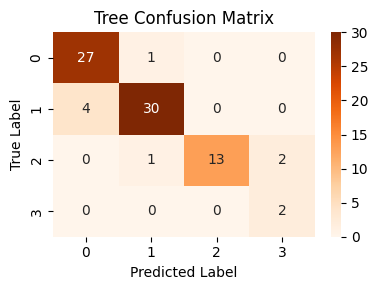

In [29]:
Tree = DecisionTree(max_depth=3)
Tree.fit(X_train.values, y_train.values)
y_pred_Tree = Tree.predict(X_test.values)

# Evaluation
accuracy_Tree = accuracy_score(y_test, y_pred_Tree)
class_report_Tree = classification_report(y_test, y_pred_Tree)
conf_matrix_Tree = confusion_matrix(y_test, y_pred_Tree)

# Output results
print("\nAccuracy:", accuracy_Tree)
print("\nClassification Report:\n", class_report_Tree)

# Plot it
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_Tree, annot=True, fmt="d", cmap="Oranges")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Tree Confusion Matrix")
plt.tight_layout()
plt.show()


### **<span style="color:rgb(0, 255, 0);">[Predicting my Grade]</span>**

my preprocessed info is here:

In [30]:
personal_data = pd.DataFrame([{
    'IsUniPR':0,
    'IsMale':1,
    'age':22,
    'fromCity':1,
    'travelTime':2,
    'studyTime':4,
    'failures':0,
    'universitySupport':0,
    'paid':0,
    'EduTendency':1,
    'HasInternet':1,
    'romantic':0,
    'freeTime':2,
    'goOut':2,
    'absences':10,
    'EPSGrade':18.5,
    'DSGrade':17.3,
    'reason_course':0,
    'reason_home':0,
    'reason_reputation':1,
    'alc':1,
    'parentEdu':4
}])


In [31]:
Xt[numerical_features] = scaler.fit_transform(Xt[numerical_features])
personal_data[numerical_features] = scaler.transform(personal_data[numerical_features])

Xt[ordinal_features] = scaler.fit_transform(Xt[ordinal_features])
personal_data[ordinal_features] = scaler.transform(personal_data[ordinal_features])

here is my normalized info

In [32]:
personal_data

,IsUniPR,IsMale,age,fromCity,travelTime,studyTime,failures,universitySupport,paid,EduTendency,...,freeTime,goOut,absences,EPSGrade,DSGrade,reason_course,reason_home,reason_reputation,alc,parentEdu
0,0,1,1.4,1,0.333333,1.0,0.0,0,0,1,...,0.25,0.25,0.133333,0.966667,0.910526,0,0,1,0.0,1.0


In [33]:
NB.predict(personal_data)

array([3])

In [34]:
DT.predict(personal_data)

array([3])

In [35]:
ODT.predict(personal_data)

array([3])

In [36]:
RF.predict(personal_data)

array([3])

In [37]:
ORF.predict(personal_data)

array([3])

In [38]:
XGB.predict(personal_data)

array([3])

In [39]:
OXGB.predict(personal_data)

array([3])

In [40]:
Tree.predict(personal_data.values)

array([3])

#### **<span style="color:rgb(0, 255, 255);">[Result]</span>**

as we can see my Grade will be in range 17-20 based on models!

### **<span style="color:rgb(0, 255, 0);">[Comparison]</span>**

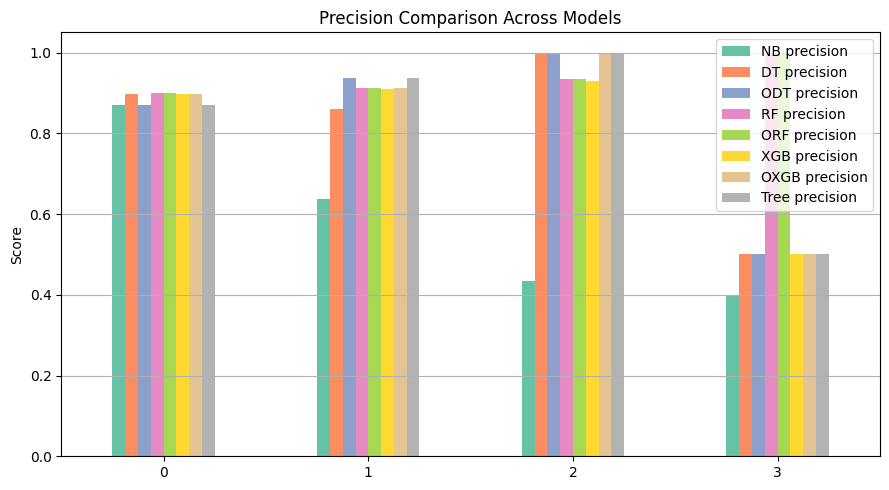

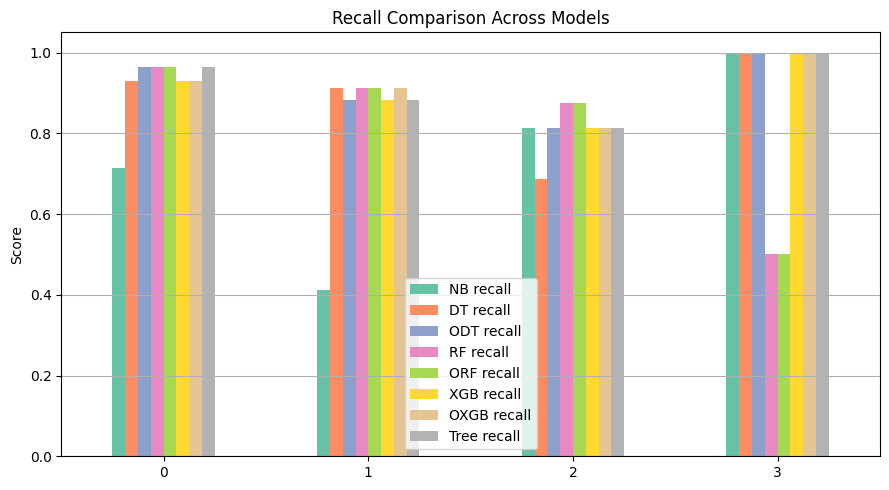

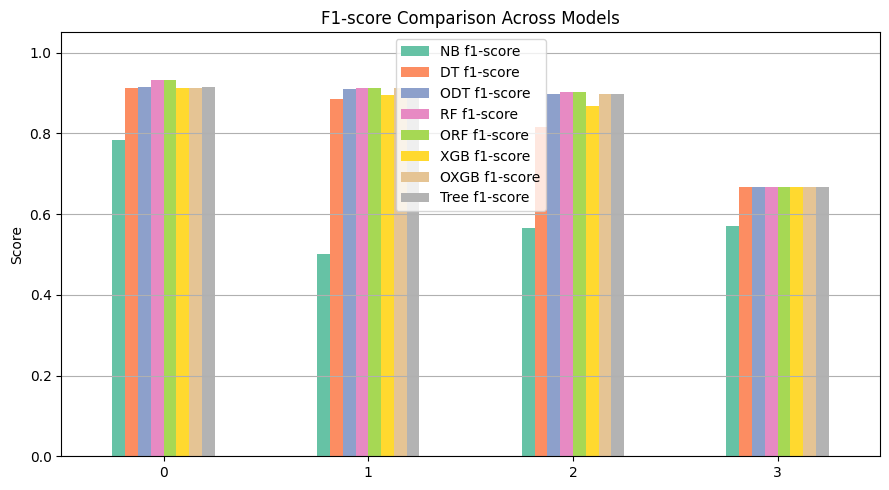

In [41]:
report_nb  = classification_report(y_test, y_pred_NB,  output_dict=True)
report_dt  = classification_report(y_test, y_pred_DT,  output_dict=True)
report_odt  = classification_report(y_test, y_pred_ODT,  output_dict=True)
report_rf  = classification_report(y_test, y_pred_RF,  output_dict=True)
report_orf  = classification_report(y_test, y_pred_ORF,  output_dict=True)
report_xgb = classification_report(y_test, y_pred_XGB, output_dict=True)
report_oxgb = classification_report(y_test, y_pred_OXGB, output_dict=True)
report_tr  = classification_report(y_test, y_pred_Tree,  output_dict=True)

df_nb  = pd.DataFrame(report_nb).transpose()
df_dt  = pd.DataFrame(report_dt).transpose()
df_odt  = pd.DataFrame(report_odt).transpose()
df_rf  = pd.DataFrame(report_rf).transpose()
df_orf  = pd.DataFrame(report_orf).transpose()
df_xgb = pd.DataFrame(report_xgb).transpose()
df_oxgb = pd.DataFrame(report_oxgb).transpose()
df_tr  = pd.DataFrame(report_tr).transpose()


# Select only precision/recall/f1-score rows
metrics = ['precision', 'recall', 'f1-score']
classes = df_nb.index.drop(['accuracy', 'macro avg', 'weighted avg'])

# Combine for plotting
combined_df = pd.DataFrame(index=classes)

for model_name, df in zip(['NB', 'DT','ODT', 'RF','ORF', 'XGB','OXGB','Tree'],
                          [df_nb, df_dt,df_odt, df_rf, df_orf, df_xgb, df_oxgb,df_tr]):
    for metric in metrics:
        combined_df[f'{model_name} {metric}'] = df.loc[classes, metric]

# Plot for each metric separately
for metric in metrics:
    plt.figure(figsize=(9, 5))
    cols = [col for col in combined_df.columns if metric in col]
    combined_df[cols].plot(kind='bar', ax=plt.gca(), colormap='Set2')
    plt.title(f'{metric.capitalize()} Comparison Across Models')
    plt.ylabel('Score')
    plt.ylim(0, 1.05)
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


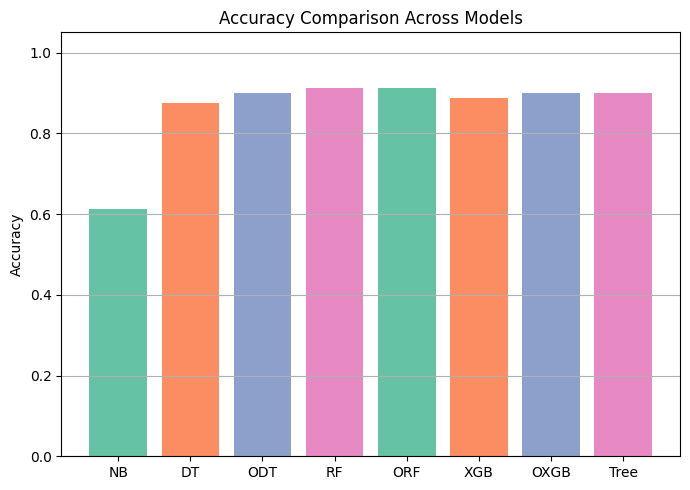

In [42]:
accuracy_scores = {
    'NB': accuracy_NB,
    'DT': accuracy_DT,
    'ODT': accuracy_ODT,
    'RF': accuracy_RF,
    'ORF': accuracy_ORF,
    'XGB': accuracy_XGB,
    'OXGB': accuracy_OXGB,
    'Tree': accuracy_Tree
}

plt.figure(figsize=(7, 5))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'])
plt.ylim(0, 1.05)
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison Across Models")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### **<span style="color:rgb(0, 255, 0);">[Appendix]</span>**

here I want to train Random Forest based on only one predicators: `DSGrade`!

In [43]:
XA_train_1 = XA_train.copy()
XA_test_1 = XA_test.copy()

Columns_1 = list(personal_data.keys())
Columns_1.remove('DSGrade')

XA_train_1 = XA_train_1.drop(columns=Columns_1)
XA_test_1 = XA_test_1.drop(columns=Columns_1)

scaler_1 = MinMaxScaler()
XA_train_1[['DSGrade']] = scaler_1.fit_transform(XA_train_1[['DSGrade']])
XA_test_1[['DSGrade']] = scaler_1.transform(XA_test_1[['DSGrade']])


Accuracy: 0.9

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.92        28
           1       0.94      0.88      0.91        34
           2       1.00      0.81      0.90        16
           3       0.50      1.00      0.67         2

    accuracy                           0.90        80
   macro avg       0.83      0.91      0.85        80
weighted avg       0.92      0.90      0.90        80



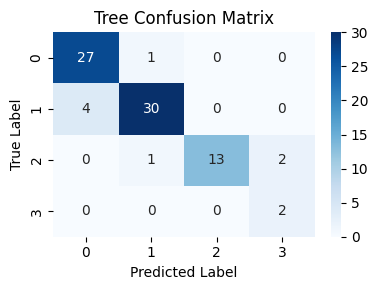

In [44]:
RF_A1 = RandomForestClassifier(random_state=42)
RF_A1.fit(XA_train_1, yA_train)

# Predict
y_pred_RF_A1 = RF_A1.predict(XA_test_1)

# Evaluation
accuracy_RF_A1 = accuracy_score(yA_test, y_pred_RF_A1)
class_report_RF_A1 = classification_report(yA_test, y_pred_RF_A1)
conf_matrix_RF_A1 = confusion_matrix(yA_test, y_pred_RF_A1)

# Output results
print("\nAccuracy:", accuracy_RF_A1)
print("\nClassification Report:\n", class_report_RF_A1)

# Plot it
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_RF_A1, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Tree Confusion Matrix")
plt.tight_layout()
plt.show()